In [ ]:
import covamd
import numpy as np

In [2]:
class Harmonic:
    def __init__(self, k: float, r0: float, name="harmonic"):
        self.k = k
        self.r0 = r0
        self.name = name
        
    def __call__(self, r: float):
        return 0.5*self.k*(r - self.r0)

In [ ]:
@ct.electron
def gradient_descent_particle_update(particles: List[Particle], dx: List[float], domain: Domain):
    for index, particle in enumerate(particles):
        particle.x += dx[index]
        particle.y += dx[index+1]
        
        particle.x = particle.x%domain.lx
        particle.y = particle.y%domain.ly
        
    return particles

@ct.electron
def check_loss(f_old: float, f_new: float):
    return abs(f_new - f_old)


@ct.electron
def scale_gradients(gradients: List[float], lr: float):
    res = []
    for value in gradients:
        res.append(-1.0*lr*value)
    return res

@ct.electron
def update_learning_rate(lr: float, f: float, step: int):
    if f < 0.0:
        return lr / 4.0
    
    if step % 10 == 0:
        return lr / 2.0
    return lr


@ct.electron
def euler_step(particles, dt: float):
    for particle in particles:
        particle.x += particle.vx*dt
        particle.y += particle.vy*dt
        
    return particles

@ct.electron
def lj_force(r, epsilon, sigma):
    """
    Implementation of the Lennard-Jones potential 
    to calculate the force of the interaction.
    
    Parameters
    ----------
    r: float
        Distance between two particles (Å)
    epsilon: float 
        Potential energy at the equilibrium bond 
        length (eV)
    sigma: float 
        Distance at which the potential energy is 
        zero (Å)
    
    Returns
    -------
    float
        Force of the van der Waals interaction (eV/Å)
    """
    return 48 * epsilon * np.power(
        sigma / r, 13) - 24 * epsilon * np.power(
        sigma / r, 7)

@ct.electron
def verlet_integration(step: int, particles: List[Particles], particles_prev: List[Particles],
                       potential: Potential, domain: Domain,dt: float):
    p_copy = copy.deepcopy(particles)

    if step == 0:
        for particle in particles:
            particle.x += particle.vx*dt
            particle.y += particle.vy*dt
            
            particle.x = particle.x%domain.lx
            particle.y = particle.y%domain.ly
    else:
        particles = update_forces(particles, potential, domain)
    
        #particles_copy = copy.deepcopy(particles)
        for index, particle in enumerate(particles):
            particle.x = 2*particle.x - particles_prev[index].x + particle.fx*dt**2
            particle.y = 2*particle.y - particles_prev[index].y + particle.fy*dt**2
            particle.x = particle.x%domain.lx
            particle.y = particle.y%domain.ly
            #print(index, particle.x, particle.y, particle.vx, particle.vy, particle.fx, particle.fy)
        
    return particles, p_copy



    #loss_value = 1e10
    
    #for i in range(maxiter):
    #    gradients = gradient(particles)
    #    dx = scale_gradients(gradients=gradients, lr=lr)
        
        # Update particle positions
    #    particles = gradient_descent_particle_update(particles=particles, dx=dx, domain=domain)
        
        # Save system
    #    save_snapshot(particles, i)
        
        # Compute potential energy
    #    f_new = objective(particles)
        
        # Check loss
    #    loss = check_loss(f_old=f_old, f_new=f_new, tol=tol)
        
    #    f_old = f_new
        
        # update learning rate based on f_new and step
    #    lr = update_learning_rate(lr, f_new, i)
        
    #    i += 1
    
    
    # Compute total energy
    #pe = total_pe(particles=particles, potential=potential, domain=domain)
    
    #ke = total_ke(particles=particles)
    
    #total_energy = pe + ke

In [ ]:
class Potential(object):
    """
    Base class for all MD potentials
    """
    def __init__(self, name: str):
        self.name = name

    def __call__(self, r: float):
        raise NotImplementedError

In [ ]:
class LennardJones(Potential):
    """
    Lennard Jones 12-6 potential class
    Input(s)
    epsilon = interaction strength
    sigma = potential interaction length scale
    cutoff = distance beyond which the potential is zero
    """
    def __init__(self, epsilon: float, sigma: float, cutoff: float = 2.5, name = "lj12/6"):
        self.epsilon = epsilon
        self.sigma = sigma
        self.cutoff = cutoff
        super().__init__(name=name)

    def __call__(self, r: float):
        """
        Compute the potential value given the distance `r`.
        The potential is set to 0 if r > cutoff
        """
        if r <= self.cutoff:
            return 4*self.epsilon*((self.sigma/r)**12 - (self.sigma/r)**6)
        return 0.0
        

In [ ]:
class Domain(object):
    def __init__(self, xlo: float, xhi: float, ylo: float, yhi: float):
        self.xlo = xlo
        self.xhi = xhi
        self.ylo = ylo
        self.yhi = yhi


    @property
    def lx(self):
        return self.xhi - self.xlo

    @property
    def ly(self):
        return self.yhi - self.ylo

In [ ]:
class Particle(object):
    def __init__(self, id: int, mass: float, x: float, y: float,
                 vx: float = 0.0, vy: float = 0.0, fx: float = 0.0,
                 fy: float = 0.0):
        """
        Basic particle
        """
        self.id = id
        self.mass = mass
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.fx = fx
        self.fy = fy

    def __eq__(self, other):
        return all([other.__dict__[key] == value for key, value in
                   self.__dict__.items()])

    def __sub__(self, other):
        return self.x - other.x, self.y - other.y

    def __repr__(self):
        return f"Particle(id={self.id}, mass={self.mass},x={self.x},\
                y={self.y},vx={self.vx},vy={self.vy},\
                fx={self.fx},fy={self.fy})".replace('\n', '')

    def __str__(self):
        return f"""{self.id},{self.mass},{self.x},{self.y},{self.vx},{self.vy},{self.fx},{self.fy}\n"""

def create_particle(id: int, mass: float, domain: Domain):
    """
    Create a particle with id=`id` and mass=`mass' randomly
    located in the domain
    """
    return Particle(id=id, mass=mass,
                    x=np.random.uniform(domain.xlo, domain.xhi),
                    y=np.random.uniform(domain.ylo, domain.yhi))

In [ ]:
domain = Domain(xlo = 0, xhi = 20, ylo = 0, yhi = 20)
num_particles = 30
nsteps = 1000
particles = [create_particle(id=index, mass=1.0, domain = domain) for index in range(num_particles)]

In [ ]:
lj = LennardJones(epsilon=1.0, sigma=1.0)

In [ ]:
#covamd.total_pe(particles, lj, domain)

In [ ]:
particles[0].x

In [ ]:
import covamd
import covalent as ct

In [ ]:
@ct.electron
def my_c_identity(x):
    return covamd.identity(x)

In [ ]:
@ct.lattice
def workflow(x):
    return my_c_identity(x)

In [ ]:
res = ct.dispatch_sync(workflow)(1.0)

In [ ]:
res.result

In [ ]:
import covalent as ct
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
@ct.electron
def fit_xy(x, y):
    z = np.polyfit(x, y, 3)
    return np.poly1d(z)

@ct.electron
def plot_fit(x, y, xnew, fit):
    y_new = np.polyval(fit, xnew)
    fig, ax = plt.subplots()
    plt.plot(x, y, 'o')
    plt.plot(xnew, y_new, '-')
    #plt.xlim([x[0]-1, x[-1]+1])
    return fig

@ct.lattice
def exp(x, y):
    x_new = np.linspace(x[0], x[-1], 50)
    fit = fit_xy(x, y)
    return plot_fit(x, y, x_new, fit)

In [ ]:
res = ct.dispatch_sync(exp)(x = [1,2,3,9], y = [1,4,1,3])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import covalent as ct

In [ ]:
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

In [ ]:
@ct.electron
def load_dataset():
    return datasets.load_digits().data

In [ ]:
@ct.electron
def build_svm_classifier(gamma: float):
    return svm.SVC(gamma=gamma)

In [ ]:
data = load_dataset()

In [ ]:
np.asarray(data.feature_names)

In [52]:
import covalent as ct
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
@ct.electron
def load_dataset():
    return datasets.load_digits()

In [4]:
@ct.electron
def build_classifier(gamma: float):
    return svm.SVC(gamma = gamma)

In [5]:
@ct.electron
def split_data(features, targets, test_set_size):
    return train_test_split(features, targets, test_size=test_set_size, shuffle=False)

In [6]:
@ct.electron
def train_classifier(clf, features, targets):
    return clf.fit(features, targets)

In [44]:
@ct.electron(executor="local")
def get_predictions(clf, test_features):
    return clf.predict(test_features)

In [39]:
@ct.electron
def get_classification_report(y_test, predicitions):
    return metrics.classification_report(y_test, predicitions)

In [40]:
@ct.lattice
def classify_digits(gamma: float):
    dataset = load_dataset()
    clf = build_classifier(gamma=gamma)
    x_train, x_test, y_train, y_test = split_data(features=dataset.data,
                                                targets=dataset.target,
                                                  test_set_size=0.5)
    
    clf = train_classifier(clf=clf, features=x_train, targets=y_train)
    
    predictions = get_predictions(clf=clf, test_features=x_test)
    
    clf_report = get_classification_report(y_test=y_test, predicitions=predictions)
    
    return predictions, clf_report

In [45]:
res = ct.dispatch(classify_digits)(0.001)

In [64]:
predictions, clf_report = ct.get_result(dispatch_id=res, wait=True).result

In [59]:
digits = datasets.load_digits()
data = digits.data

In [60]:

# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.001)

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False
)

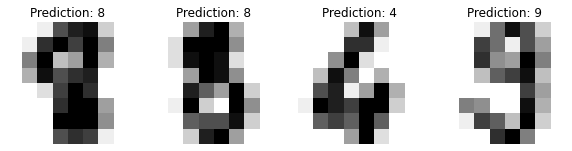

In [65]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, prediction in zip(axes, X_test, predictions):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Prediction: {prediction}")